<a href="https://colab.research.google.com/github/nitaymayo/My_Portfolio/blob/main/AI/Tensorflow/Transfer_Learning_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning From Tensorflow-hub

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
! nvidia-smi

Thu Dec  8 12:21:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Importing the data
import zipfile 

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-12-08 12:21:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.9MB/s    in 7.8s    

2022-12-08 12:21:59 (20.6 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Inspecting the data
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"dir: {len(dirnames)}, images: {len(filenames)}, in {dirpath}")

dir: 2, images: 0, in 10_food_classes_10_percent
dir: 10, images: 0, in 10_food_classes_10_percent/train
dir: 0, images: 75, in 10_food_classes_10_percent/train/grilled_salmon
dir: 0, images: 75, in 10_food_classes_10_percent/train/ice_cream
dir: 0, images: 75, in 10_food_classes_10_percent/train/sushi
dir: 0, images: 75, in 10_food_classes_10_percent/train/pizza
dir: 0, images: 75, in 10_food_classes_10_percent/train/steak
dir: 0, images: 75, in 10_food_classes_10_percent/train/chicken_wings
dir: 0, images: 75, in 10_food_classes_10_percent/train/chicken_curry
dir: 0, images: 75, in 10_food_classes_10_percent/train/fried_rice
dir: 0, images: 75, in 10_food_classes_10_percent/train/hamburger
dir: 0, images: 75, in 10_food_classes_10_percent/train/ramen
dir: 10, images: 0, in 10_food_classes_10_percent/test
dir: 0, images: 250, in 10_food_classes_10_percent/test/grilled_salmon
dir: 0, images: 250, in 10_food_classes_10_percent/test/ice_cream
dir: 0, images: 250, in 10_food_classes_10_pe

##Data loaders

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Generating datasets

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

data_gen = ImageDataGenerator(rescale=1/255.)

train_data = data_gen.flow_from_directory(train_dir,
                                          batch_size=BATCH_SIZE,
                                          target_size=IMAGE_SHAPE,
                                          class_mode="categorical"
                                          )

test_data = data_gen.flow_from_directory(test_dir,
                                          batch_size=BATCH_SIZE,
                                          target_size=IMAGE_SHAPE,
                                          class_mode="categorical"
                                          )

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Callbacks

### tensorboard callback

In [ ]:
from datetime import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.now().strftime("%Y%m%d%H%m%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"saving tensorboard callback to {log_dir}")
  return tensorboard_callback

## tensorflow hub

In [ ]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
def create_model(model_url, num_classes=10, image_shape=IMAGE_SHAPE):
  """
  takes tensorflow hub url and creates a keras Sequential model with it.

  Args:
    model_url (str): tensorflow hub URL
    num_classes (int): number of units in the output layer

  Returns:
    an un compiled keras Sequential model
  """

  feature_extraction_layer = hub.KerasLayer(model_url,
                                            trainable=False,
                                            name="feature_extractrion_layer",
                                            input_shape=image_shape+(3,))
  model = tf.keras.Sequential([
      feature_extraction_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

In [ ]:
resnet_model = create_model(resnet_url)

resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractrion_layer (  (None, 2048)             23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compile the model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
# Train the model
resnet_history = resnet_model.fit(train_data,
                 epochs=5,
                 validation_data=test_data,
                 callbacks=[create_tensorboard_callback("tensorflow_hub", "resnet50v2")])

saving tensorboard callback to tensorflow_hub/resnet50v2/20221208121214
Epoch 1/5
24/24 [==============================] - 29s 756ms/step - loss: 1.9593 - accuracy: 0.3360 - val_loss: 1.2007 - val_accuracy: 0.6208
Epoch 2/5
24/24 [==============================] - 16s 691ms/step - loss: 0.8912 - accuracy: 0.7453 - val_loss: 0.8261 - val_accuracy: 0.7416
Epoch 3/5
24/24 [==============================] - 17s 712ms/step - loss: 0.6044 - accuracy: 0.8387 - val_loss: 0.7380 - val_accuracy: 0.7588
Epoch 4/5
24/24 [==============================] - 16s 681ms/step - loss: 0.4700 - accuracy: 0.8787 - val_loss: 0.7026 - val_accuracy: 0.7720
Epoch 5/5
24/24 [==============================] - 16s 690ms/step - loss: 0.3755 - accuracy: 0.9173 - val_loss: 0.6672 - val_accuracy: 0.7824


In [ ]:
# Visualize the training
import pandas as pd
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  DF = pd.DataFrame(history.history)
  plt.subplot(1,2,1)
  plt.title("acc")
  plt.xlabel("epochs")
  plt.ylabel("acc")
  plt.plot(DF["accuracy"], label="acc")
  plt.plot(DF["val_accuracy"], label="val acc")
  plt.legend()

  plt.subplot(1,2,2)
  plt.title("loss")
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.plot(DF["loss"], label="loss")
  plt.plot(DF["val_loss"], label="val loss")
  plt.legend()

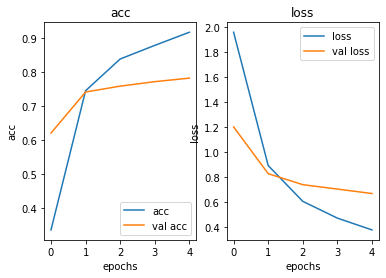

In [ ]:
plot_loss_curves(resnet_history)

###building efficientnet model

In [ ]:
# Build, Compile and Train a model based on Efficientnet architecture
efficientnet_model = create_model(efficientnet_url)

efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])
efficientnet_history = efficientnet_model.fit(train_data,
                                               epochs=5,
                                               validation_data=test_data,
                                               callbacks=[create_tensorboard_callback("tensorflow_hub", "efficientnet_b0")])

saving tensorboard callback to tensorflow_hub/efficientnet_b0/20221208121202
Epoch 1/5
24/24 [==============================] - 25s 723ms/step - loss: 1.7991 - accuracy: 0.4773 - val_loss: 1.2902 - val_accuracy: 0.7364
Epoch 2/5
24/24 [==============================] - 15s 657ms/step - loss: 1.0389 - accuracy: 0.7893 - val_loss: 0.8612 - val_accuracy: 0.8156
Epoch 3/5
24/24 [==============================] - 24s 1s/step - loss: 0.7420 - accuracy: 0.8387 - val_loss: 0.6961 - val_accuracy: 0.8404
Epoch 4/5
24/24 [==============================] - 15s 654ms/step - loss: 0.5988 - accuracy: 0.8573 - val_loss: 0.6061 - val_accuracy: 0.8568
Epoch 5/5
24/24 [==============================] - 16s 683ms/step - loss: 0.5075 - accuracy: 0.8933 - val_loss: 0.5527 - val_accuracy: 0.8580


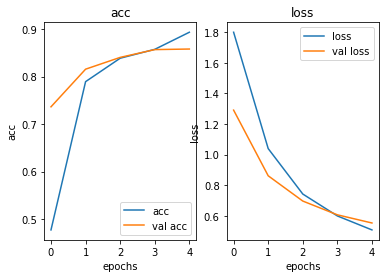

In [ ]:
plot_loss_curves(efficientnet_history)

## Uploding data to tensorboard

In [ ]:
! tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientnetB0 VS ResNet50V2" \
  --description "comparing two diffrent transfer learning architectures" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) NO
